In [3]:
import sys

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets
from dal_toolbox.models.deterministic import DeterministicTrainer

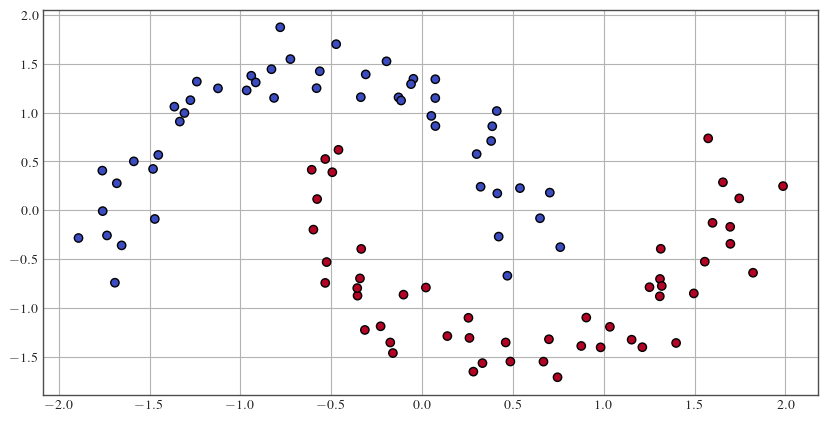

In [4]:
X, y = datasets.make_moons(100, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [6]:
from dal_toolbox.models.deterministic.base import DeterministicModule
from dal_toolbox.models.utils.callbacks import MetricsHistory

class Model(DeterministicModule):
    def __init__(self,
                 num_classes: int = 2,
                 dropout_rate: int = .2,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-3)
        return optimizer

In [7]:
@torch.no_grad()
def plot_contour(model, domain=5, ax=None):
    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [1] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.7032 (0.7032) acc1: 50.0000 (50.0000) time: 0.0028 data: 0.0009 max mem: 18
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.6229 (0.6229) acc1: 70.0000 (70.0000) time: 0.0021 data: 0.0006 max mem: 18
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.5235 (0.5235) acc1: 87.0000 (87.0000) time: 0.0018 data: 0.0006 max mem: 18
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.4359 (0.4359) acc1: 86.0000 (86.0000) time: 0.0015 data: 0.0006 max mem: 18
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.3831 (0.3831) acc1: 84.0000 (84.0000) time: 0.0019 data: 0.0006 max mem: 18
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.3465 (0.3465) acc1: 86.0000 (86.0000) time: 0.0022 data: 0.0010 max mem: 18
Epoch [6] Total time: 0:00:00
Epoch [7] [0/1] eta: 0:00:00 lr: 0.1000 loss: 0.3430 (0.3430) acc1: 87.0000 

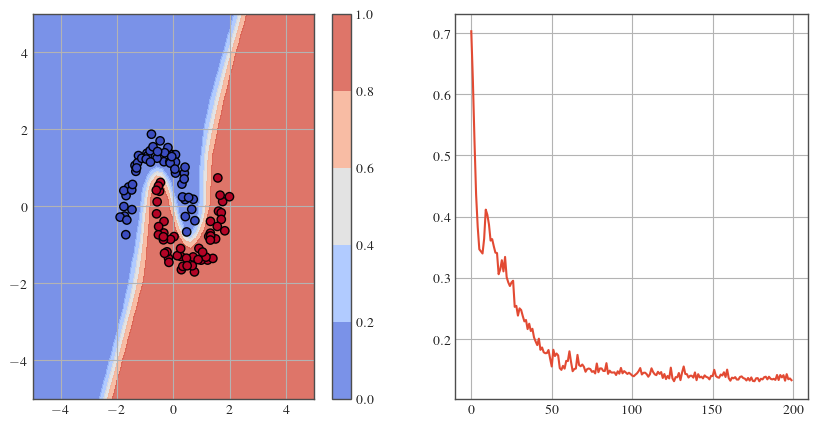

In [18]:
num_epochs = 100
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

#model = Model()
# history = MetricsHistory()
# trainer = L.Trainer(max_epochs=num_epochs, callbacks=[history])
# trainer.fit(model, train_loader)

model = Model()
trainer = DeterministicTrainer(
    model=model,
    criterion=nn.CrossEntropyLoss(label_smoothing=0.05),
    optimizer=model.configure_optimizers(),
)
history = trainer.fit(train_loader)

model.eval()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y)
plot_contour(model)
plt.subplot(122)
plt.plot([h['train_loss'] for h in history['train_history']])
plt.show()